## Imports

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from impedance.models.circuits import CustomCircuit
# from impedance.visualization import plot_nyquist # Kept if you want to switch plotting methods

## Data Loading

In [119]:
# --- Data Loading ---

def lpr_cor_import(filename):
    """ Import cor file as pandas dataframe."""

    try: 
        df = pd.read_csv(
            filename,
            skiprows=26,
            sep='\s+',
            header=None,
            names=["E", "i", "T"],
        ) #index_col="Freq")
    except FileNotFoundError as e:
        print(f"Error: File was not found.")
        print(e.message)
        print(e.args)
        return None
    except Exception as e:
        print(f"Error reading the CSV file: {e}")
        return None   
    else:
        return df

In [127]:
HS1_1 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_1.cor")
HS1_2 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_2.cor")
HS1_3 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_3.cor")
HS1_4 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_4.cor")
HS1_5 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_5.cor")
HS1_6 = lpr_cor_import("HIPed_Stellite1_LPR/LPR_6.cor")


# Keep it in the same cell to keep df reproducible, even if Vi clicks it multiple times
area = 2 #cm^2
kernel_size = 5

for df in [HS1_1, HS1_2, HS1_3, HS1_4, HS1_5, HS1_6]:
    df["i"] = np.abs(df["i"]/area) # Current density
    #df["i"] = medfilt(df["i"], kernel_size=kernel_size)
    df.drop(df.head(60).index, inplace=True)
    df.drop(df.tail(60).index, inplace=True)

In [128]:
HS1_1

E             i      T
60   -0.206243  4.571450e-11    6.1
61   -0.206232  4.584480e-11    6.2
62   -0.206221  4.593445e-11    6.3
63   -0.206212  4.600095e-11    6.4
64   -0.206202  4.606290e-11    6.5
...        ...           ...    ...
3939 -0.167438  7.020500e-11  394.0
3940 -0.167428  7.005000e-11  394.1
3941 -0.167417  6.993800e-11  394.2
3942 -0.167407  6.988100e-11  394.3
3943 -0.167398  6.985750e-11  394.4

[3884 rows x 3 columns]

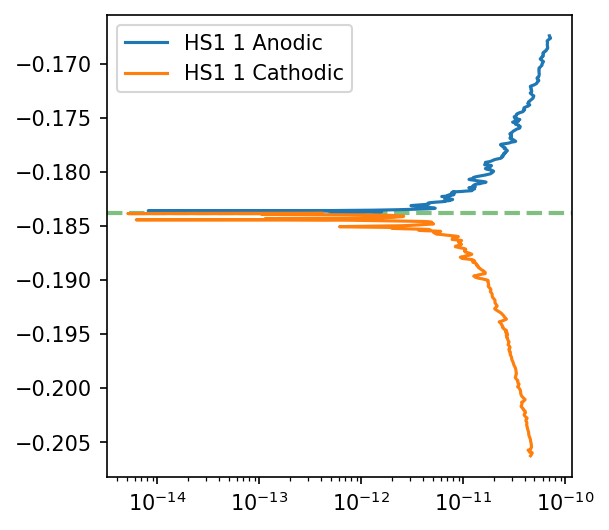

In [129]:
fig, ax = plt.subplots(figsize=(4,4), sharex=True, dpi=150)
kernel_size = 49

# Step 1
# Filter the data a lil bit with a median filter, and find the lowest current, and then find the corresponding voltage
Ecorr_guess = HS1_1['E'].iloc[ np.argmin(medfilt(HS1_1['i'], kernel_size=kernel_size)) ]
ax.axhline(y=Ecorr_guess, color='green', linestyle='--', linewidth=2, alpha=0.5)


# Step 2
# Select data for anodic and cathodic Tafel regions
anodic_df =  HS1_1[HS1_1['E'] > Ecorr_guess] 
cathodic_df =  HS1_1[HS1_1['E'] < Ecorr_guess] 


ax.semilogx(
    np.abs(anodic_df["i"].to_numpy()),
    anodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Anodic")

ax.semilogx(
    np.abs(cathodic_df["i"].to_numpy()),
    cathodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Cathodic")


ax.legend()
plt.show()

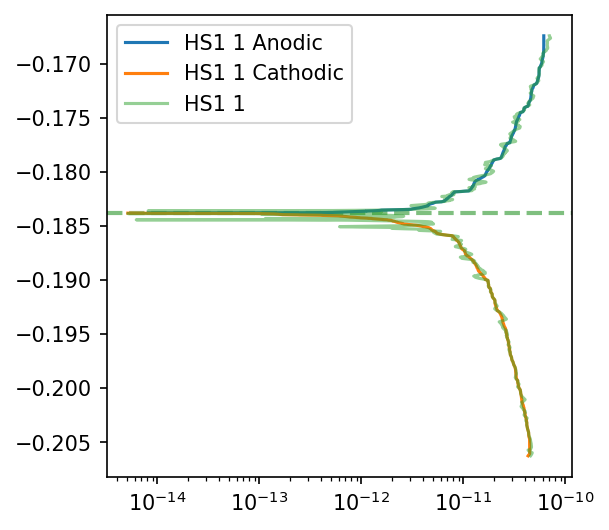

In [130]:
import warnings

fig, ax = plt.subplots(figsize=(4,4), sharex=True, dpi=150)
kernel_size = 49

# Step 1
# Filter the data a lil bit with a median filter, and find the lowest current, and then find the corresponding voltage
Ecorr_guess = HS1_1['E'].iloc[ np.argmin(medfilt(HS1_1['i'], kernel_size=kernel_size)) ]
ax.axhline(y=Ecorr_guess, color='green', linestyle='--', linewidth=2, alpha=0.5)


# Step 2
# Select data for anodic and cathodic Tafel regions
anodic_df =  HS1_1[HS1_1['E'] > Ecorr_guess] 
cathodic_df =  HS1_1[HS1_1['E'] < Ecorr_guess] 

if anodic_df.empty or cathodic_df.empty:
    warnings.warn("Warning: Not enough data for linear Tafel fit.")
    warnings.warn("Your E_corr guess is probably wrong.")
        
# Step 3
# Median filter the hell out of the data, cos it isn't going to change the magnitude of the data :D
kernel_size = 299
medfilt_anodic_df_i = medfilt(anodic_df["i"], kernel_size=kernel_size)
medfilt_cathodic_df_i = medfilt(cathodic_df["i"], kernel_size=kernel_size)

ax.semilogx(
    medfilt_anodic_df_i,
    #np.abs(anodic_df["i"].to_numpy()),
    anodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Anodic")

ax.semilogx(
    medfilt_cathodic_df_i,
    #np.abs(cathodic_df["i"].to_numpy()),
    cathodic_df["E"].to_numpy(), 
    markersize=5, label="HS1 1 Cathodic")

ax.semilogx(
    np.abs(HS1_1['i'].to_numpy()),
    HS1_1["E"].to_numpy(), 
    markersize=5, label="HS1 1", alpha=0.5)

ax.legend()
plt.show()

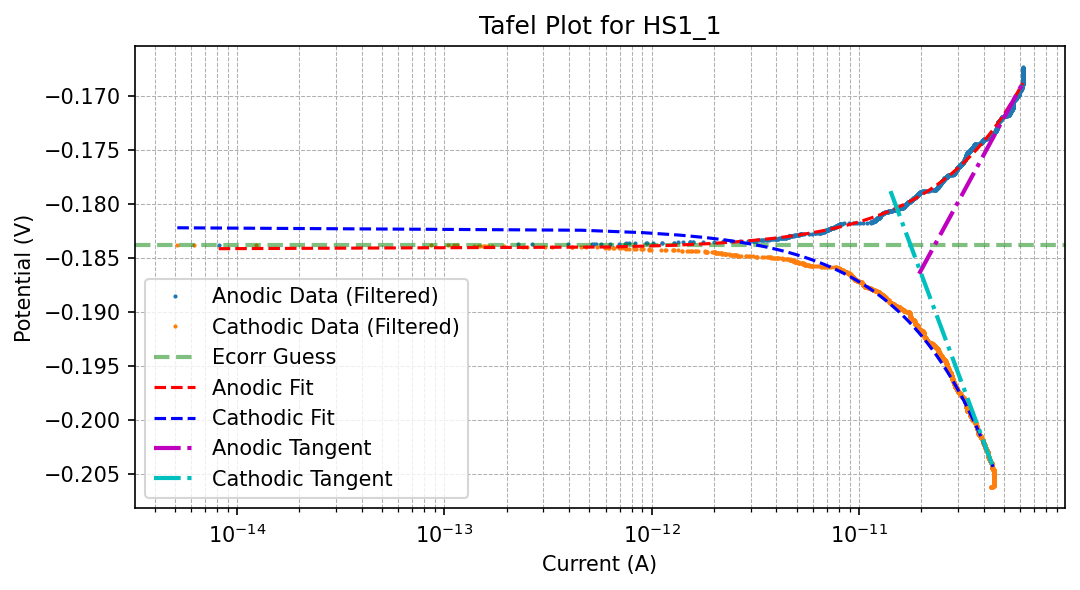

In [145]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt


# --- 1. Initial Prep ---
fig, ax = plt.subplots(figsize=(8, 4), dpi=150) 

# Apply a median filter to the current data to smooth out noise
KERNEL_SIZE_INITIAL = 49 
filtered_current = medfilt(HS1_1['i'], kernel_size=KERNEL_SIZE_INITIAL)

# Plot the filtered experimental data on a semilog x-axis
ax.semilogx(medfilt_anodic_i, anodic_df["E"], 'o', markersize=1, label="Anodic Data (Filtered)")
ax.semilogx(medfilt_cathodic_i, cathodic_df["E"], 'o', markersize=1, label="Cathodic Data (Filtered)")


# --- 2. Data Segmentation for Tafel Analysis ---

# Estimate the corrosion potential (Ecorr) by finding the potential
# at the minimum value of the smoothed current.
ecorr_guess_index = np.argmin(filtered_current)
ecorr_guess = HS1_1['E'].iloc[ecorr_guess_index]

# Plot the estimated Ecorr as a horizontal dashed line
ax.axhline(y=ecorr_guess, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Ecorr Guess')

# Split the dataset into anodic and cathodic regions based on the Ecorr guess
anodic_df = HS1_1[HS1_1['E'] > ecorr_guess]
cathodic_df = HS1_1[HS1_1['E'] < ecorr_guess]

# Check if the dataframes are empty and issue a warning if so
if anodic_df.empty or cathodic_df.empty:
    warnings.warn("Warning: Insufficient data for a linear Tafel fit. Your Ecorr guess may be incorrect.")


# --- 3. Advanced Filtering and Curve Fitting ---

# Define a larger kernel size for more aggressive filtering of the segmented data
KERNEL_SIZE_FIT = 299

# Apply median filter to the current in both anodic and cathodic regions
medfilt_anodic_i = medfilt(anodic_df["i"], kernel_size=KERNEL_SIZE_FIT)
medfilt_cathodic_i = medfilt(cathodic_df["i"], kernel_size=KERNEL_SIZE_FIT)

# Perform a linear fit (degree 1) for the Tafel plots (E vs. log(i))
# Note: We fit E as a function of the filtered current
p_anodic = np.poly1d(np.polyfit(medfilt_anodic_i, anodic_df["E"], 1))
p_cathodic = np.poly1d(np.polyfit(medfilt_cathodic_i, cathodic_df["E"], 1))

# Generate points for the fit lines for a smooth plot
i_anodic_fit = np.linspace(medfilt_anodic_i.min(), medfilt_anodic_i.max(), 100)
i_cathodic_fit = np.linspace(medfilt_cathodic_i.min(), medfilt_cathodic_i.max(), 100)

# Plot the Tafel fit lines
ax.plot(i_anodic_fit, p_anodic(i_anodic_fit), 'r--', label='Anodic Fit')
ax.plot(i_cathodic_fit, p_cathodic(i_cathodic_fit), 'b--', label='Cathodic Fit')


# --- 4. Tangent Line Calculation and Plotting ---

def plot_tangent(p_fit, filtered_i, color, label):
    """Calculates and plots the tangent line at the point of maximum current."""
    # Point of tangency
    i_extreme = filtered_i.max()
    E_extreme = p_fit(i_extreme)

    # Slope of the tangent on a semilog plot (dE/d(log10(i)))
    # dE/di is the slope of the linear fit (p_fit.coeffs[0])
    # di/d(log10(i)) = i * ln(10)
    tangent_slope = p_fit.coeffs[0] * (i_extreme * np.log(10))

    # Equation of the tangent line: E = m*(log10(i) - log10(i_0)) + E_0
    log_i_extreme = np.log10(i_extreme)
    log_i_tangent = np.linspace(log_i_extreme - 0.5, log_i_extreme, 100)
    E_tangent = tangent_slope * (log_i_tangent - log_i_extreme) + E_extreme

    ax.plot(10**log_i_tangent, E_tangent, color=color, linestyle='-.', linewidth=2, label=label)

# Plot the tangent lines for both anodic and cathodic fits
plot_tangent(p_anodic, medfilt_anodic_i, 'm', 'Anodic Tangent')
plot_tangent(p_cathodic, medfilt_cathodic_i, 'c', 'Cathodic Tangent')


# --- 5. Final Plot Configuration ---

# Set plot labels and title for clarity
ax.set_xlabel("Current (A)")
ax.set_ylabel("Potential (V)")
ax.set_title("Tafel Plot for HS1_1")
ax.legend()
ax.grid(True, which="both", ls="--", linewidth=0.5)

# Display the plot
plt.show()

In [132]:
def linear_tafel_fit(df, overpotential_range_V=0.1):

    ecorr_index = df['abs_j'].idxmin()
    Ecorr_guess = df['E_V'].iloc[ecorr_index]

    # Select data for anodic and cathodic Tafel regions
    anodic_df = df[df['E_V'] > (Ecorr_guess + overpotential_range_V)]
    cathodic_df = df[df['E_V'] < (Ecorr_guess - overpotential_range_V)]
    
    if anodic_df.empty or cathodic_df.empty:
        print("Warning: Not enough data for linear Tafel fit.")
        return None

    # Fit linear regions (log(j) vs E)
    # np.polyfit returns [slope, intercept] for a 1st degree polynomial
    # We want E vs log(j), so we swap x and y
    p_anodic = np.polyfit(anodic_df['log_abs_j'], anodic_df['E_V'], 1)
    p_cathodic = np.polyfit(cathodic_df['log_abs_j'], cathodic_df['E_V'], 1)

    beta_a = p_anodic  # Anodic Tafel slope (V/decade)
    beta_c = -p_cathodic # Cathodic Tafel slope (V/decade), should be positive

    # Find intersection of the two lines to get Ecorr and log(icorr)
    # E = beta_a * log(j) + intercept_a
    # E = -beta_c * log(j) + intercept_c
    log_icorr = (p_cathodic - p_anodic) / (p_anodic - p_cathodic)
    icorr = 10**log_icorr
    Ecorr = p_anodic * log_icorr + p_anodic

    return {
        'Ecorr_V': Ecorr,
        'icorr_A_cm2': icorr,
        'beta_a_V_dec': beta_a,
        'beta_c_V_dec': beta_c
    }